## DL assignment #1 

> Name: Chenrui Fan\
> Student ID: 23-125-818
> Github: 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL
import requests
from tqdm.notebook import tqdm
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are using {}".format(device))

We are using cuda


### 1. [Total 60 pts] Train a fully connected neural network and convolutional neural network for binary classification.

#### [10 pts] Create Dataset and DataLoader objects for provided training and validation data (folders train and val). Visualize few images from each class.

Create datasets and dataloaders

In [26]:
import os
from PIL import Image

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.image_paths = []
        self.image_labels = []
        for index, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.image_labels.append(index)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.image_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = ChestXrayDataset(root_dir='chest_xray_64/train', transform=transform)
val_dataset = ChestXrayDataset(root_dir='chest_xray_64/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Visualize few images from each class

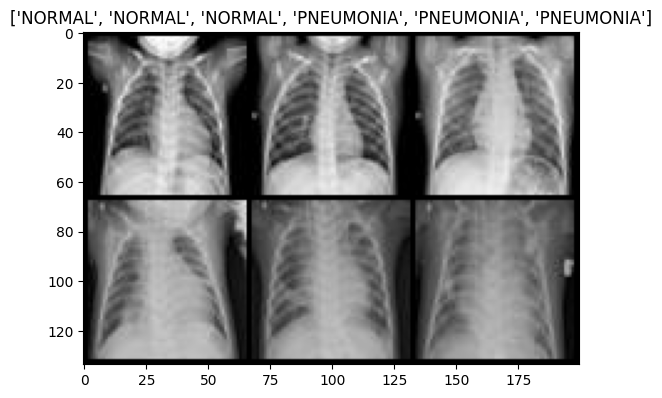

In [30]:
class_images = {cls: [] for cls in range(len(train_dataset.classes))}
for images, classes in train_loader:
    for image, cls in zip(images, classes):
        cls_index = cls.item()
        if len(class_images[cls_index]) < 3:
            class_images[cls_index].append(image)
    if all(len(imgs) == 3 for imgs in class_images.values()):
        break
images = [img for imgs in class_images.values() for img in imgs]
classes = [cls for cls in class_images.keys() for _ in range(3)]
out = torchvision.utils.make_grid(images, nrow=3)
imshow(out, title=[train_dataset.classes[x] for x in classes])

#### [10 pts] Implement the MLP model according to the definition below:
– Fully connected layer, out features=128\
– Activation function ReLU\
– Fully connected layer, out features=128\
– Activation function ReLU\
– Fully connected layer, out features=128\
– Activation function ReLU\
– Fully connected layer, out features=128\
– Activation function ReLU\
– Fully connected layer, out features=2

In [4]:
from torch import nn

class MLP(nn.Module):
    def __init__(self, input_features = 3 * 64 * 64):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_features, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=12288, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)


#### [15 pts] Implement a convolutional model according to the definition below:
– Convolutional layer, kernel size 3x3, stride 1, 32 channels\
– Max Pooling layer, kernel size 3x3, stride 2, ceil mode=True\
– Activation function ReLU\
– Convolutional layer, kernel size 3x3, stride 1, 64 channels\
– Max Pooling layer, kernel size 3x3, stride 2\
– Activation function ReLU\
– Convolutional layer, kernel size 3x3, stride 1, 64 channels\
– Max Pooling layer, kernel size 2x2, stride 2\
– Activation function ReLU\
– Convolutional layer, kernel size 2x2, stride 1, 128 channels\
– Activation function ReLU\
– Convolutional layer, kernel size 3x3, stride 1, 256 channels\
– Activation function ReLU\
– Convolutional layer, kernel size 3x3, stride 1, 256 channels\
– Activation function ReLU\
– Convolutional layer, kernel size 1x1, stride 1, 2 (output) channels

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=2, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool1(self.conv1(x)))
        x = self.relu(self.pool2(self.conv2(x)))
        x = self.relu(self.pool3(self.conv3(x)))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.conv7(x)
        x = torch.flatten(x, 1)
        return x
    
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)


#### [20 pts] Write the training code and train the network you implemented.
– Train for 30 epochs with a batch size of 32.\
– Optimize the cross entropy loss.\
– Use Adam optimizer with learning rate 1e-3.

In [6]:
from torch import optim

def train(model, batchsize, epochs, model_name, train_dataset, val_dataset, save_path='weights'):

    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_train = []
    loss_val = []
    accuracy_train = []
    accuracy_val = []
    best_val_accuracy = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        train_accuracy = 100 * train_correct / train_total
        loss_train.append(train_loss)
        accuracy_train.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = 100 * val_correct / val_total
        loss_val.append(val_loss)
        accuracy_val.append(val_accuracy)

        # The training still continues and the final visualization section uses the same LOSS and ACCURACY from the last round.
        # Here is just to save the best model.
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model_save_path = os.path.join(save_path, f'{model_name}.pth')
            os.makedirs(save_path, exist_ok=True)
            torch.save(model.state_dict(), model_save_path)

        print(f'Epoch {epoch + 1}/{epochs} Training Loss: {train_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}% Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%')
    print('Finished Training and Evaluation')

    return loss_train, loss_val, accuracy_train, accuracy_val

For visualizing

In [7]:
def visualize(loss_train, loss_val, accuracy_train, accuracy_val):

    epochs_range = range(1, len(loss_train) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss_train, label='Training Loss')
    plt.plot(epochs_range, loss_val, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracy_train, label='Training Accuracy')
    plt.plot(epochs_range, accuracy_val, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

##### Train the MLP model

In [8]:
model_MLP = MLP().to(device)
loss_train_MLP, loss_val_MLP, accuracy_train_MLP, accuracy_val_MLP = train(model_MLP, batchsize = 32, epochs = 30, train_dataset = train_dataset, val_dataset = val_dataset, model_name = 'MLP')

Epoch 1/30 Training Loss: 0.3433, Accuracy: 85.77% Validation Loss: 0.4094, Accuracy: 82.05%
Epoch 2/30 Training Loss: 0.2046, Accuracy: 92.04% Validation Loss: 0.3497, Accuracy: 82.53%
Epoch 3/30 Training Loss: 0.1477, Accuracy: 94.77% Validation Loss: 0.9464, Accuracy: 73.24%
Epoch 4/30 Training Loss: 0.1391, Accuracy: 94.79% Validation Loss: 1.5360, Accuracy: 66.03%
Epoch 5/30 Training Loss: 0.1351, Accuracy: 95.23% Validation Loss: 0.6809, Accuracy: 78.21%
Epoch 6/30 Training Loss: 0.1340, Accuracy: 94.73% Validation Loss: 0.7378, Accuracy: 75.00%
Epoch 7/30 Training Loss: 0.1240, Accuracy: 95.09% Validation Loss: 0.9875, Accuracy: 71.63%
Epoch 8/30 Training Loss: 0.1146, Accuracy: 95.80% Validation Loss: 0.4330, Accuracy: 81.89%
Epoch 9/30 Training Loss: 0.1286, Accuracy: 95.51% Validation Loss: 0.5328, Accuracy: 78.85%
Epoch 10/30 Training Loss: 0.1247, Accuracy: 95.65% Validation Loss: 0.5546, Accuracy: 79.17%
Epoch 11/30 Training Loss: 0.1191, Accuracy: 95.51% Validation Loss: 

#### [5 pts] Include plots for the training and validation losses and accuracies.

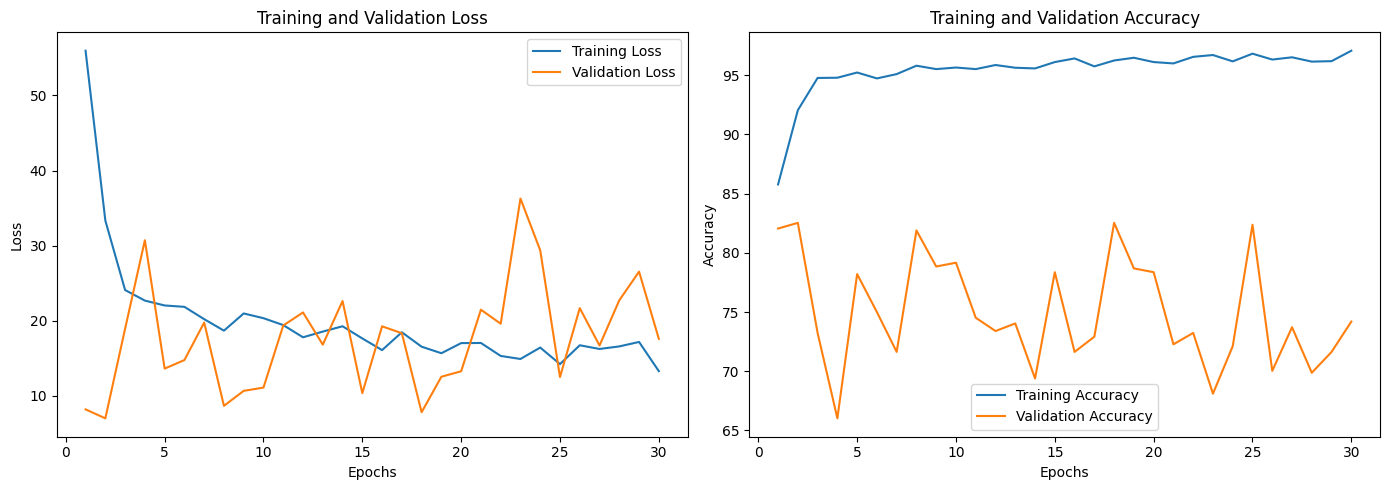

In [9]:
visualize(loss_train_MLP, loss_val_MLP, accuracy_train_MLP, accuracy_val_MLP)

##### Train the CNN model

In [10]:
model_CNN = CNN().to(device)
loss_train_CNN, loss_val_CNN, accuracy_train_CNN, accuracy_val_CNN = train(model_CNN, batchsize = 32, epochs = 30, train_dataset = train_dataset, val_dataset = val_dataset, model_name = 'CNN')

Epoch 1/30 Training Loss: 0.5270, Accuracy: 81.37% Validation Loss: 0.4529, Accuracy: 80.29%
Epoch 2/30 Training Loss: 0.1899, Accuracy: 93.02% Validation Loss: 0.3643, Accuracy: 84.78%
Epoch 3/30 Training Loss: 0.1400, Accuracy: 94.65% Validation Loss: 0.5395, Accuracy: 82.05%
Epoch 4/30 Training Loss: 0.1187, Accuracy: 95.63% Validation Loss: 0.7108, Accuracy: 79.17%
Epoch 5/30 Training Loss: 0.1058, Accuracy: 96.01% Validation Loss: 0.8179, Accuracy: 75.96%
Epoch 6/30 Training Loss: 0.0946, Accuracy: 96.57% Validation Loss: 0.6036, Accuracy: 80.93%
Epoch 7/30 Training Loss: 0.0873, Accuracy: 96.61% Validation Loss: 1.1437, Accuracy: 72.28%
Epoch 8/30 Training Loss: 0.0736, Accuracy: 97.28% Validation Loss: 0.5474, Accuracy: 82.69%
Epoch 9/30 Training Loss: 0.0737, Accuracy: 97.05% Validation Loss: 0.7142, Accuracy: 79.49%
Epoch 10/30 Training Loss: 0.0550, Accuracy: 97.97% Validation Loss: 0.9822, Accuracy: 75.80%
Epoch 11/30 Training Loss: 0.0644, Accuracy: 97.60% Validation Loss: 

#### [5 pts] Include plots for the training and validation losses and accuracies.

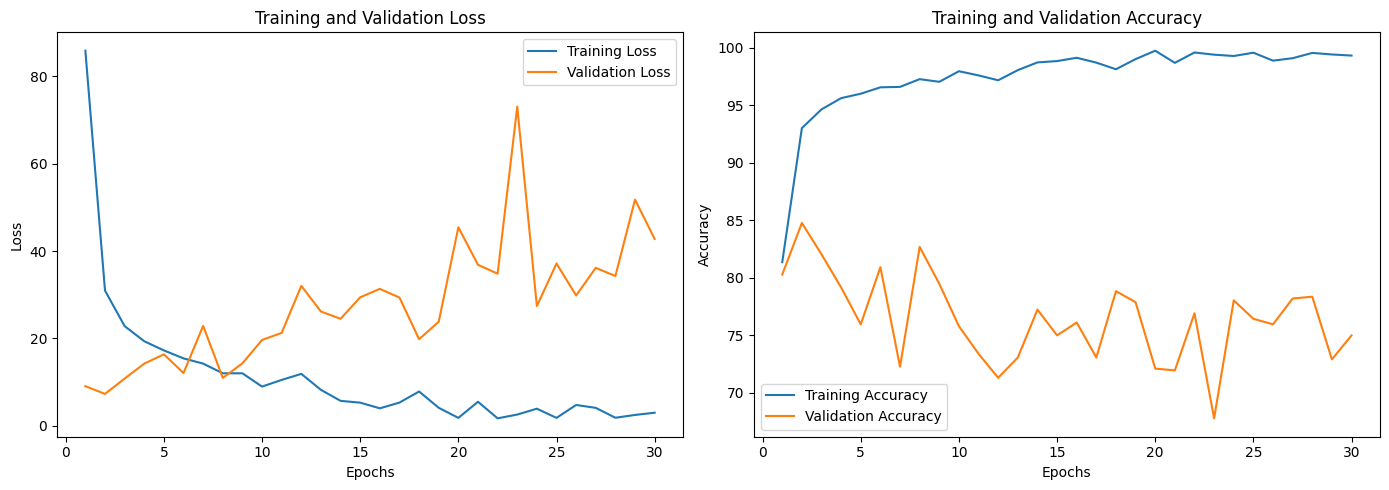

In [11]:
visualize(loss_train_CNN, loss_val_CNN, accuracy_train_CNN, accuracy_val_CNN)

### 2. [ Total 30 pts] Add Regularization to your convolutional (CNN) model
Regularization is a common technique used in deep learning to prevent over-
fitting in models. In this task, you should choose two popular regularization
techniques.

#### [15 pts] Train a convolutional neural network with the first regularization technique you have chosen.

##### First technique


Data augmentation

In [12]:
train_augment_transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomCrop((64, 64)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

val_augment_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_aug_dataset = ChestXrayDataset(root_dir='chest_xray_64/train', transform=train_augment_transform)
val_aug_dataset = ChestXrayDataset(root_dir='chest_xray_64/val', transform=val_augment_transform)


In [13]:
model_CNN_aug = CNN().to(device)
loss_train_CNN_aug, loss_val_CNN_aug, accuracy_train_CNN_aug, accuracy_val_CNN_aug = train(model_CNN_aug, batchsize = 32, epochs = 30, train_dataset = train_aug_dataset, val_dataset = val_aug_dataset, model_name = 'CNN_Aug')

Epoch 1/30 Training Loss: 0.7014, Accuracy: 72.16% Validation Loss: 0.5809, Accuracy: 63.78%
Epoch 2/30 Training Loss: 0.4124, Accuracy: 82.76% Validation Loss: 0.4288, Accuracy: 82.69%
Epoch 3/30 Training Loss: 0.3323, Accuracy: 85.53% Validation Loss: 0.3822, Accuracy: 85.10%
Epoch 4/30 Training Loss: 0.2787, Accuracy: 88.31% Validation Loss: 0.4022, Accuracy: 84.78%
Epoch 5/30 Training Loss: 0.2610, Accuracy: 89.49% Validation Loss: 0.5669, Accuracy: 75.16%
Epoch 6/30 Training Loss: 0.2651, Accuracy: 89.49% Validation Loss: 0.3208, Accuracy: 86.70%
Epoch 7/30 Training Loss: 0.2388, Accuracy: 89.80% Validation Loss: 0.3770, Accuracy: 84.94%
Epoch 8/30 Training Loss: 0.2360, Accuracy: 90.26% Validation Loss: 0.3472, Accuracy: 85.26%
Epoch 9/30 Training Loss: 0.2163, Accuracy: 91.10% Validation Loss: 0.5006, Accuracy: 78.53%
Epoch 10/30 Training Loss: 0.2170, Accuracy: 91.39% Validation Loss: 0.3922, Accuracy: 83.33%
Epoch 11/30 Training Loss: 0.2032, Accuracy: 91.76% Validation Loss: 

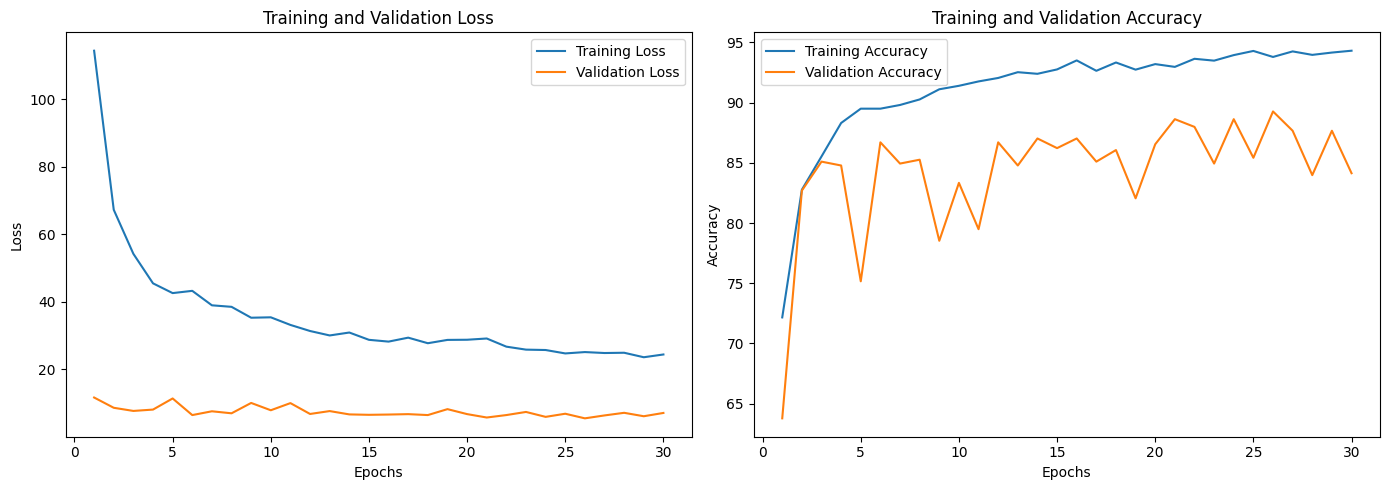

In [14]:
visualize(loss_train_CNN_aug, loss_val_CNN_aug, accuracy_train_CNN_aug, accuracy_val_CNN_aug)

#### [15 pts] Train a convolutional neural network with the second regularization technique you have chosen.

##### Second technique


Dropout

In [15]:
class CNN_dropout(CNN):
    def __init__(self, dropout_conv=0.2, dropout_fc=0.5):
        super(CNN_dropout, self).__init__()
        self.dropout_conv = nn.Dropout(p=dropout_conv)
        self.dropout_fc = nn.Dropout(p=dropout_fc)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(self.dropout_conv(x))
        x = self.relu(self.conv2(x))
        x = self.pool2(self.dropout_conv(x))
        x = self.relu(self.conv3(x))
        x = self.pool3(self.dropout_conv(x))
        x = self.dropout_conv(self.relu(self.conv4(x)))
        x = self.dropout_conv(self.relu(self.conv5(x)))
        x = self.dropout_conv(self.relu(self.conv6(x)))
        x = self.dropout_fc(self.conv7(x))
        x = torch.flatten(x, 1)
        return x

In [16]:
model_CNN_drop = CNN().to(device)
loss_train_CNN_drop, loss_val_CNN_drop, accuracy_train_CNN_drop, accuracy_val_CNN_drop = train(model_CNN_drop, batchsize = 32, epochs = 30, train_dataset = train_dataset, val_dataset = val_dataset, model_name = 'CNN_drop')

Epoch 1/30 Training Loss: 0.6201, Accuracy: 77.34% Validation Loss: 0.9988, Accuracy: 70.51%
Epoch 2/30 Training Loss: 0.1866, Accuracy: 92.79% Validation Loss: 0.3911, Accuracy: 82.37%
Epoch 3/30 Training Loss: 0.1286, Accuracy: 94.90% Validation Loss: 0.5852, Accuracy: 81.09%
Epoch 4/30 Training Loss: 0.1194, Accuracy: 95.34% Validation Loss: 0.3199, Accuracy: 88.30%
Epoch 5/30 Training Loss: 0.1082, Accuracy: 95.90% Validation Loss: 0.7021, Accuracy: 79.81%
Epoch 6/30 Training Loss: 0.0981, Accuracy: 96.32% Validation Loss: 0.6059, Accuracy: 80.93%
Epoch 7/30 Training Loss: 0.0695, Accuracy: 97.53% Validation Loss: 0.4579, Accuracy: 81.09%
Epoch 8/30 Training Loss: 0.0691, Accuracy: 97.41% Validation Loss: 0.7882, Accuracy: 77.56%
Epoch 9/30 Training Loss: 0.0624, Accuracy: 97.66% Validation Loss: 0.9709, Accuracy: 76.92%
Epoch 10/30 Training Loss: 0.0490, Accuracy: 98.22% Validation Loss: 0.7978, Accuracy: 82.37%
Epoch 11/30 Training Loss: 0.0473, Accuracy: 98.26% Validation Loss: 

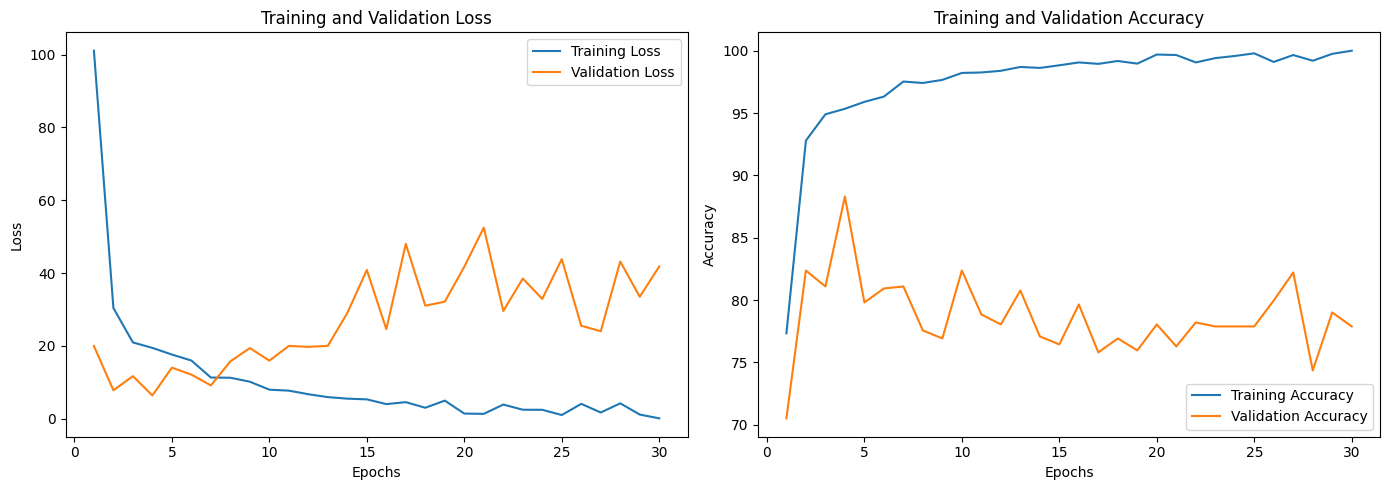

In [17]:
visualize(loss_train_CNN_drop, loss_val_CNN_drop, accuracy_train_CNN_drop, accuracy_val_CNN_drop)

### 3. [10 pts] Comment the results.
At the conclusion (last cell) of your Jupyter notebook, please provide the final
validation accuracies for the following scenarios:
- Validation accuracy for a fully connected neural network.
- Validation accuracy for a convolutional neural network.
- Validation accuracy for a convolutional neural network with the first regularization technique applied.

Save result for visualizing

In [18]:
save_list = [loss_val_MLP, accuracy_val_MLP, loss_val_CNN, accuracy_val_CNN, loss_val_CNN_aug, accuracy_val_CNN_aug, loss_val_CNN_drop, accuracy_val_CNN_drop]
file_path = 'val_loss_accuracy.npy'
np.save(file_path, save_list)

Reload loss and accuracy

In [19]:
file_path = 'val_loss_accuracy.npy'
loaded_list = np.load(file_path, allow_pickle=True)
(loss_val_MLP_loaded, accuracy_val_MLP_loaded, loss_val_CNN_loaded, accuracy_val_CNN_loaded, 
 loss_val_CNN_aug_loaded, accuracy_val_CNN_aug_loaded, loss_val_CNN_drop_loaded, 
 accuracy_val_CNN_drop_loaded) = loaded_list

Comparison

In [25]:
table_data = [
    ['Model Type', 'Val Loss', 'Val Accuracy'],
    ['MLP', loss_val_MLP[-1], accuracy_val_MLP[-1]], 
    ['CNN', loss_val_CNN[-1], accuracy_val_CNN[-1]],
    ['CNN with Data augmentation', loss_val_CNN_aug[-1], accuracy_val_CNN_aug[-1]],
    ['CNN with Dropout', loss_val_CNN_drop[-1], accuracy_val_CNN_drop[-1]],
]
print("{: >26}| {: >10}| {: >20}".format(*table_data[0]))
print('-'.join(['' for i in range(65)]))
for row in table_data[1:]:
    print("{: >26}| {:10.4f}| {: >20}".format(*row))

                Model Type|   Val Loss|         Val Accuracy
----------------------------------------------------------------
                       MLP|    17.5844|    74.19871794871794
                       CNN|    42.7787|                 75.0
CNN with Data augmentation|     7.0483|    84.13461538461539
          CNN with Dropout|    41.8179|    77.88461538461539


### Comments

#### Highest scoring model

> The CNN with Data Augmentation model performed the best with an accuracy of 84.13% and the lowest validation loss of 7.0483.

#### Reasons for Success

> Data Augmentation is an effective technique to generate more training samples by applying transformations (Although here I only used random crop and horizontal flip) to the training data. This helps the model to generalize better to unseen data, especially in image recognition tasks. 

#### Potential methods to enhance accuracy

> `Hyperparameter tuning:` Tuning hyperparameters such as network structure (like number of layers, number of neurons per layer and so on) and learning rate may do some help.

> `Regularization techniques:` In addition to Dropout, other regularization techniques such as L1 and L2 regularization can be explored to reduce overfitting(I didn't show this method, in fact, you can combine multiple regularization methods, like early stop and so on).

> `More complex model architectures:` Using more advanced convolutional neural network architectures such as ResNet, Inception, or Transformer, which may be able to capture more complex features.

> `Enhanced datasets:` Collect more training data or utilize unlabeled data to enhance model learning through semi-supervised learning or self-supervised learning techniques.

#### Analysis of other model performance mismatches

> `MLP:` It is usually inferior to CNN for image recognition tasks because it is not able to capture the local structure and hierarchical relationships of an image efficiently.

> `CNN:` Pure CNN is an improvement over MLP as it is able to capture the spatial hierarchy of an image, but without data augmentation or proper regularization, it may not generalize sufficiently.

> `CNN with Dropout:` Although Dropout is an effective technique for reducing overfitting, it does not change the nature of the input data. In contrast, data augmentation directly increases the diversity and complexity of the input data, allowing the model to learn a wider range of feature representations. Particularly in image processing tasks, due to the high dimensionality and complexity of image data, it is often more effective to increase the diversity of the training samples by physically altering the images than by simply modifying the activation patterns within the network.